## Imports

In [1]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from IPython.display import display

sns.set_style('whitegrid')

## Load Data

In [3]:
data =  pd.read_csv('../processed_data/remote_process/train_none_rf_impute_cv_xrb_pulsar' , index_col = 'obs_id')
data = data.sample(frac=1).iloc[:,1:]
data.head()

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,bb_ampl_lolim,bb_ampl_hilim,bb_stat,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_OBS_512,CV,CXOGLB J002406.0-72045,CV0081,25.99,-15.038105,-15.356745,-15.061630,-14.935917,-14.621239,-15.327533,...,0.000000,0.000000,1.000,14.0000,27.0000,7.000,118.00,134.00,122.000,1.000
NS_OBS_116,XRB,GRS 1741.9-2853,NS0021,376.06,-12.892790,-12.134126,-12.766750,-12.242680,-12.084547,-13.016870,...,0.000204,0.000313,1.952,6.3270,10.3000,4.389,13.81,22.52,6.202,0.999
PULSAR_OBS_27,PULSAR,PSR J0357+3205,PL0008,20.23,-13.227752,-13.763715,-13.695941,-14.230401,-13.078210,-13.273273,...,0.003887,0.005112,1.152,0.4546,0.5124,0.402,11.91,15.96,8.223,0.946
PULSAR_OBS_274,PULSAR,PSR J1745-2900,PL0081,107.91,-13.670602,-15.243897,-13.661942,-13.199077,-12.996109,-13.726767,...,0.000160,0.000223,2.692,2.8190,3.5120,2.271,12.73,15.59,10.080,1.659
BH_OBS_28,XRB,SAX J1819.3-2525,BH0009,26.51,-15.185153,-13.000000,-14.000000,-15.044408,-14.878112,-16.050415,...,0.000000,0.000000,1.000,14.0000,28.0000,8.000,157.00,184.00,173.000,1.000


In [55]:
info_col = [ 'class' , 'src_n' , 'src_id' , 'significance']
data_info = data[info_col]
data_val = data.drop(columns=info_col) 
data_label = data['class']

In [56]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier()

# Hyper Parameter Tuning

In [4]:
rfc_v2 = RandomForestClassifier()

## Random Search

In [5]:
from sklearn.model_selection import RandomizedSearchCV

In [59]:
n_estimators = [int(x) for x in np.linspace(80 , 500 , num=40)]
max_features = ['log2' , 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 150, num = 40)]
min_samples_split = [int(x) for x in np.linspace(2,20 ,num = 30)]
min_samples_leaf = [int(x) for x in np.linspace(2,30 , num = 30)]
bootstrap = [True , False]

In [60]:
params_dict = {
    'n_estimators' : n_estimators , 
    'max_features' : max_features ,
    'max_depth' :max_depth , 
    'min_samples_split' : min_samples_split , 
    'min_samples_leaf' : min_samples_leaf, 
    'bootstrap' : bootstrap 
}

In [61]:
rs = RandomizedSearchCV(
    rfc_v2 , 
    params_dict , 
    n_iter = 100,
    cv = 5 ,
    verbose = 5 ,
    n_jobs=-1 , 
    random_state= 0 
)

In [62]:
rs.fit(data_val , data_label)
rs.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': 133,
 'min_samples_split': 13,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 73,
 'bootstrap': False}

In [63]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,133,13,10,sqrt,73,False,0.781362,0.738351,0.755755,1
1,187,5,8,sqrt,12,False,0.767025,0.745520,0.754314,2
2,209,11,7,sqrt,20,False,0.774194,0.731183,0.752885,3
3,284,3,9,sqrt,119,False,0.770609,0.738351,0.750020,4
4,198,12,2,sqrt,127,False,0.767025,0.731183,0.750010,5
5,338,17,2,sqrt,130,False,0.777778,0.713262,0.750008,6
6,155,13,13,sqrt,81,True,0.774194,0.741935,0.749314,7
7,349,11,11,log2,88,False,0.767025,0.731183,0.749306,8
8,90,9,17,sqrt,96,False,0.774194,0.734767,0.748597,9
9,284,14,18,sqrt,107,False,0.759857,0.741935,0.748594,10


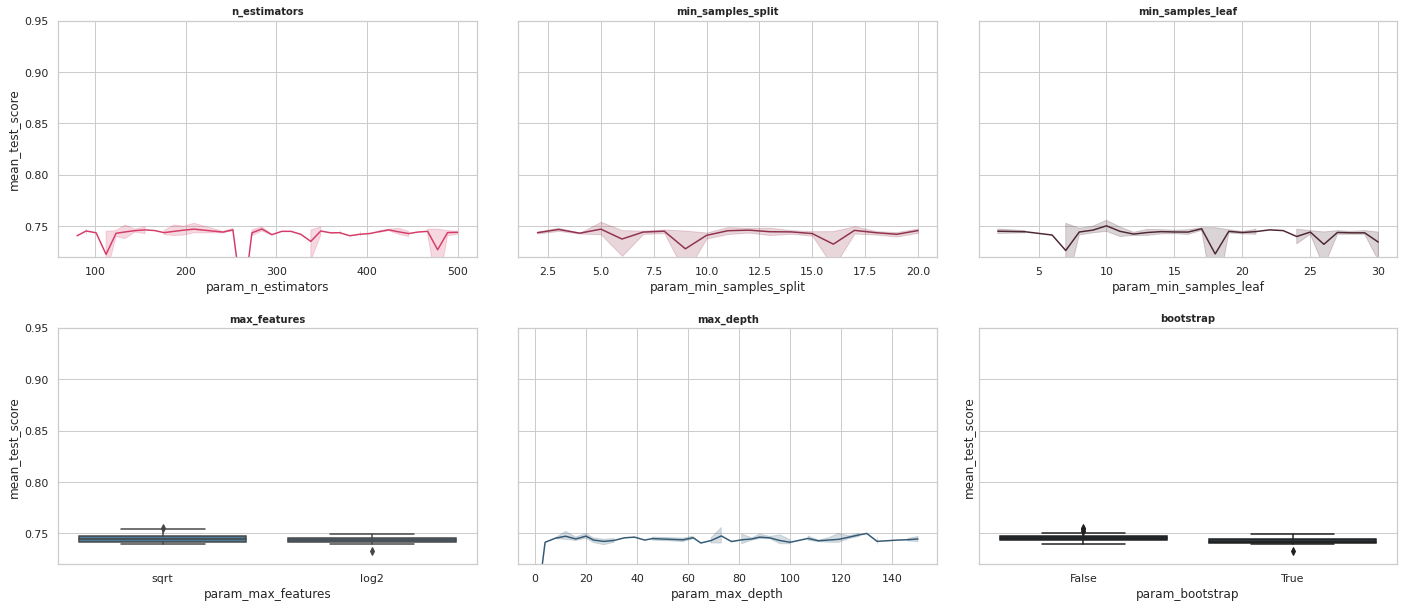

In [64]:
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
fig, axs = plt.subplots(ncols=3, nrows=2  , sharey=True)
fig.set_size_inches(24,10)
colors = sns.diverging_palette(240, 0, n=6 , center='dark')
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0],color=colors[5]) 
axs[0,0].set_ylim([.72,.95])
axs[0,0].set_title(label = 'n_estimators', size=10, weight='bold')
sns.lineplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1],color=colors[4])
#axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=10, weight='bold')
sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2],color=colors[3])
#axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=10, weight='bold')
sns.boxplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0],color=colors[0])
#axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=10, weight='bold')
sns.lineplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1],color=colors[1])
#axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=10, weight='bold')
sns.boxplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2] , color=colors[2])
#axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=10, weight='bold')
fig.subplots_adjust(wspace=0.1 , hspace=0.3)

plt.show()


### Result
> Best Model Parameters
```

{'n_estimators': 288,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 150,
 'bootstrap': False}
```
> Best Parameter values

```
{'n_estimators': [136 , 309 , 347,385],
 'min_samples_split': [7,12,44],
 'min_samples_leaf': [2,7,12],
 'max_features': 'sqrt',
 'max_depth': [43 ,85, 100],
 'bootstrap': False}
```

## Grid Search

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
n_estimators = [140 , 170 , 230]
max_features = ['sqrt'] 
bootstrap = [False]
max_depth =  [56 ,85, 100]
min_samples_leaf = [2,12]
min_samples_split = [7,18,28]

In [ ]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [ ]:
gs = GridSearchCV(rfc_v2 , param_grid , cv=5 , verbose=5 , n_jobs=-1)
gs.fit(data_val , data_label)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [56, 85, 100],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2, 12],
                         'min_samples_split': [7, 18, 28],
                         'n_estimators': [140, 170, 230]},
             verbose=5)

In [ ]:
gs.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 18,
 'n_estimators': 140}

# Best Random Forest

So Now we have identified best random Forest , lets see how its various performance are.

## Load Data

In [2]:
from features import features as feat 
all_feat = list(feat['info'])+list(feat['flux']['photon'])+list(feat['flux']['energy'])+list(feat['variability'])+list(feat['hardness'])+list(feat['model_fit']['powerlaw'])+list(feat['model_fit']['bb'])+list(feat['model_fit']['brems'])


In [4]:

feat_to_drop = list(feat['model_fit']['powerlaw']) + list(feat['model_fit']['bb']) + list(feat['model_fit']['brems']) + list(feat['info_pre_filter'])
feat_used = [item for item in all_feat if item not in feat_to_drop]

In [5]:
data_all =  pd.read_csv('../processed_data/v2/train_norm_rf_impute_xrb_pulsar' , index_col = 'obs_id').iloc[: , 1:]
data_all = data_all[data_all['class'].isin(['XRB' , 'PULSAR' , 'CV'])]
#data_all = data_all[feat_used]
display(data_all)


,class,src_n,src_id,significance,photflux_aper_hilim_b,photflux_aper_s,photflux_aper_m,photflux_aper_hilim_m,photflux_aper_lolim_u,photflux_aper_hilim_s,...,var_inter_prob,hard_hm,hard_hs,hard_ms,hard_hm_hilim,hard_hm_lolim,hard_ms_hilim,hard_hs_hilim,hard_ms_lolim,hard_hs_lolim
obs_id,,,,,,,,,,,,,,,,,,,,,
NS_OBS_128,XRB,H 1658-298,NS0024,31.12,0.540385,0.562270,0.502353,0.551732,0.291180,0.548973,...,1.00000,0.091255,0.041875,0.304983,0.111835,0.036570,0.341841,0.051297,0.278536,0.015028
NS_OBS_132,XRB,IGR J00291+5934,NS0028,18.99,0.609050,0.589294,0.570157,0.619746,0.591876,0.584547,...,0.95075,0.582499,0.456874,0.377527,0.645264,0.497150,0.443427,0.527240,0.329490,0.374192
PULSAR_OBS_293,PULSAR,PSR J1809-2332,PL0087,16.03,0.678239,0.652246,0.680697,0.710533,0.591876,0.644890,...,0.60820,0.495647,0.469382,0.473734,0.508264,0.459369,0.507980,0.503517,0.467399,0.423634
PULSAR_OBS_425,PULSAR,PSR J2032+4127,PL0125,8.11,0.537554,0.312864,0.469333,0.525314,0.591876,0.324516,...,0.90000,0.762508,0.916850,0.767511,0.802765,0.712686,0.870281,0.959589,0.703083,0.864199
NS_OBS_282,XRB,XMMU J004245.2+41172,NS0046,4.71,0.274649,0.638845,0.199048,0.304094,0.591876,0.113140,...,0.00000,0.767511,1.000000,1.000000,0.887476,0.613115,1.000000,1.000000,0.616836,0.791614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NS_OBS_90,XRB,EXO 1745-248,NS0020,23.47,0.431954,0.313735,0.460609,0.515549,0.591876,0.318089,...,0.77225,0.271263,0.538773,0.753752,0.346154,0.170139,0.839591,0.690834,0.708521,0.367330
NS_OBS_92,XRB,EXO 1745-248,NS0020,23.47,0.472759,0.319601,0.504040,0.553052,0.591876,0.327808,...,0.77225,0.351861,0.691265,0.804983,0.406389,0.269054,0.878568,0.805648,0.777856,0.560687
BH_OBS_86,XRB,CXOU J100516.2-07423,BH0020,16.78,0.319223,0.342973,0.283168,0.355406,0.213686,0.327779,...,0.46500,0.000000,0.000000,0.325645,0.064209,0.000000,0.405115,0.035892,0.260862,0.000000


In [6]:
np.random.seed(433)
data = data_all.sample(frac=1)


In [7]:
data_label = data['class']
x = data.copy()
brems_model = ['brems_nh' , 'brems_nh_lolim' , 'brems_nh_hilim' , 'brems_kt' , 'brems_kt_lolim' , 'brems_kt_hilim']
inter_obs_param = ['var_inter_index' , 'var_inter_prob' , 'var_inter_sigma' ,]
x = x.drop(columns = inter_obs_param )
y = data_label.copy()
x

,class,src_n,src_id,significance,photflux_aper_hilim_b,photflux_aper_s,photflux_aper_m,photflux_aper_hilim_m,photflux_aper_lolim_u,photflux_aper_hilim_s,...,var_sigma,hard_hm,hard_hs,hard_ms,hard_hm_hilim,hard_hm_lolim,hard_ms_hilim,hard_hs_hilim,hard_ms_lolim,hard_hs_lolim
obs_id,,,,,,,,,,,,,,,,,,,,,
NS_OBS_297,XRB,XMMU J004245.2+41172,NS0046,4.71,0.402035,0.638845,0.405274,0.507222,0.591876,0.417926,...,0.000000e+00,0.000000,0.000000,0.414999,0.468584,0.000000,0.798721,0.539461,0.221437,0.000000
PULSAR_OBS_13,PULSAR,PSR J0100-7211,PL0003,65.51,0.872367,0.868889,0.897519,0.910022,0.657361,0.866739,...,8.013802e-06,0.324995,0.277517,0.443766,0.320354,0.293619,0.456215,0.289294,0.455816,0.247157
PULSAR_OBS_38,PULSAR,PSR J0358+5413,PL0009,19.44,0.505969,0.441623,0.486527,0.533467,0.591876,0.431583,...,1.861297e-06,0.556234,0.593756,0.536872,0.587677,0.505372,0.601893,0.656175,0.507477,0.524370
BH_OBS_137,XRB,J1745-2900,BH0027,337.00,0.507865,0.638845,0.677247,0.696392,0.591876,0.081198,...,2.938191e-07,0.500000,1.000000,0.500000,0.470227,0.504414,0.488491,1.000000,0.543803,0.986826
NS_OBS_91,XRB,EXO 1745-248,NS0020,23.47,0.443667,0.231872,0.489720,0.540760,0.591876,0.247273,...,1.226379e-06,0.238743,0.748749,0.899990,0.299163,0.149357,0.961023,0.892221,0.894665,0.566949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NS_OBS_139,XRB,KS 1731-260,NS0033,14.81,0.442432,0.292253,0.462741,0.516191,0.591876,0.292368,...,2.196189e-06,0.370622,0.700020,0.796228,0.434149,0.278537,0.870281,0.807548,0.767633,0.568802
NS_OBS_341,XRB,J1748-2446,NS0057,18.31,0.413033,0.638845,0.352068,0.442038,0.591876,0.187420,...,3.063735e-06,0.736892,1.000000,1.000000,0.857067,0.583506,1.000000,1.000000,0.778509,0.866703
PULSAR_OBS_199,PULSAR,PSR J1658-5324,PL0069,4.26,0.513590,0.536061,0.483806,0.547496,0.351816,0.536004,...,3.836549e-06,0.243746,0.119372,0.311887,0.370629,0.104615,0.408951,0.206521,0.235032,0.040074


## Train and save model

{'n_estimators': 402,
 'min_samples_split': 16,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': False}

In [8]:
# Find and fit besst model
train_acc = []
test_acc = []
best_clf = ''
score = 0 
for i in tqdm(range(1)):
    rs = int(np.random.uniform(10 , 99999))
    '''
    27601 0.958974358974359
    79324
    '''
    #rs = 60328 #with brems
    #rs =  87023 #without brems works whether bb_stat included or not
    #rs = 67373 # forr all classifier
    #rs = 72035
    #rs = 31547 # for cv-xrb
    #rs = 4114 # for xrb-pulsar
    rs = 1391 # for xrb-pulsar v2
    np.random.seed(rs)

    df =  x.sample(frac=1 , random_state=rs)
    y = df['class']
    x_train , x_test , _ , _ = train_test_split(df , y , test_size=0.2 , shuffle=True, random_state=10 , stratify=y)
    info_col = ['src_n' , 'src_id' , 'significance' , 'class']
    id_train = x_train[info_col]
    id_test = x_test[info_col]
    y_train = x_train['class']
    y_test = x_test['class']
    x_train = x_train.drop(info_col , axis=1)
    x_test = x_test.drop(info_col , axis = 1 )
    #np.random.seed(5926)
    clf = RandomForestClassifier(
        n_estimators= 600 , 
        criterion='entropy' ,
        random_state=12,
        max_depth=85 , 
        min_samples_leaf= 2 , 
        min_samples_split=2 , 
        bootstrap=False ,
        max_features='sqrt' ,
        class_weight='balanced'
        )
    clf.fit(x_train , y_train)
    tr = clf.score(x_train , y_train)
    next_score = clf.score(x_test , y_test)
    if(next_score > score):
        best_clf = clf
        score = next_score
        print('better found' , rs , next_score)
    #print(next_score , score)
    #print('\n -----------------')
    #print(rs , tst)
    ##train_acc.append(tr)
    #test_acc.append(tst)

100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

better found 1391 0.9320388349514563


In [9]:
test_score =  best_clf.score(x_test , y_test)
print(test_score)

0.9320388349514563


### Save model


In [10]:
import joblib 
joblib.dump(best_clf , 'forest/xrb-pulsar.joblib' , compress=3)

['forest/xrb-pulsar.joblib']

### Entropy-Wise Feature Importance

In [23]:
feat_imp = clf.feature_importances_
feat_names = x_train.columns.to_list()
feat = pd.DataFrame()
feat.insert( 0 , 'feat_name' , feat_names)
feat.insert(1 , 'feat_imp' , feat_imp)
feat = feat.sort_values(by = 'feat_imp' , ascending=False).reset_index(drop=True)
feat_names_sorted = feat['feat_name']
display(feat)
#feat.to_csv('result/feat_imp.csv')

,feat_name,feat_imp
0,flux_aper_lolim_u,0.118613
1,photflux_aper_u,0.099422
2,var_min,0.037370
3,var_mean,0.036661
4,photflux_aper_lolim,0.033468
5,photflux_aper_hilim,0.030271
6,photflux_aper_b,0.028629
7,photflux_aper,0.026897
8,var_sigma,0.026801
9,flux_aper_hilim_u,0.026789


## Bake Result

### Function

In [40]:
def create_res_data(x , y , id_data  , cl_type):
    pred = clf.predict(x)
    pred_prob = np.asarray(clf.predict_proba(x))
    pred_prob_PULSAR = pred_prob[:,0]
    pred_prob_cv = pred_prob[:,1]
    #pred_prob_pulsar = pred_prob[:,2]
    pred_prob = [np.amax(pi) for pi in pred_prob]
    res =  x.copy()
    res = res[feat_names_sorted]
    #id_data = id_data.reset_index(drop=True)
    res.insert(0 , 'clf_type' , [cl_type]*len(res))
    res.insert(1 , 'true_class' , y)
    res.insert(2 ,'pred_class' , pred)
    res.insert(3 , 'pred_prob' , pred_prob)
    res.insert(4 , 'PULSAR_prob' , pred_prob_PULSAR)
    res.insert(5 , 'XRB_prob' , pred_prob_cv)
    #res.insert(5 , 'PULSAR_prob' , pred_prob_pulsar)
    res = pd.concat([id_data , res] , axis=1).drop('class' , axis=1)
    truth = []
    th_class = [] 
    is_ok = [] 
    for tc , pc , pp in zip(res['true_class'] , res['pred_class'] , res['pred_prob']):
        if(tc==pc): is_ok.append(1)
        else: is_ok.append(0)
        if(pp > 0.75):
            th_class.append(pc)
            if(tc==pc):
                truth.append(1)
            else: truth.append(0)
        else :
            truth.append(2)
            th_class.append('X')
    res.insert(5 , 'th_class' , th_class )
    res.insert(6 , 'truth' , truth)
    res.insert(6 , 'is_ok' , is_ok)
    return res


### Bake it

In [41]:

train_res = create_res_data(x_train , y_train ,id_train , cl_type='train')
test_res = create_res_data(x_test , y_test ,id_test , cl_type='test')
#train_res.to_csv('result/train_res_rf.csv')
#test_res.to_csv('result/test_res_rf.csv')
res_data = pd.concat([train_res , test_res])
#res_data =  res_data.set_index('obs_id')
#res_data.to_csv('../result/res_rf_tuned_rf_impute.csv')

# Result Analysis

In [42]:
cv_data = res_data[res_data['true_class']=='CV']
cv_sources = np.unique(cv_data['src_id'])
print('Num of CV sources :' , len(cv_sources))
print('Num of CV obs :' , len(cv_data))

cv_data = res_data[res_data['true_class']=='XRB']
cv_sources = np.unique(cv_data['src_id'])
print('Num of LMXRB sources :' , len(cv_sources))
print('Num of LMXRB obs :' , len(cv_data))

cv_data = res_data[res_data['true_class']=='PULSAR']
cv_sources = np.unique(cv_data['src_id'])
print('Num of PULSAR sources :' , len(cv_sources))
print('Num of PULSAR obs :' , len(cv_data))

Num of CV sources : 0
Num of CV obs : 0
Num of LMXRB sources : 66
Num of LMXRB obs : 349
Num of PULSAR sources : 81
Num of PULSAR obs : 166


In [43]:
data =  res_data.copy().query('clf_type=="test"')
#print(data)
total = len(data)
print('Total samples' , total)
am_clf = len(data[data['th_class']=='X'])
print('Ambiguous calssification : ' , am_clf)
wrong_clf = len(data[data['truth']==0])
print('Wrong calssification : ' , wrong_clf)

acc = (total-am_clf-wrong_clf)/total
print('Classification accuracy :{:.3f}'.format(acc))

Total samples 103
Ambiguous calssification :  26
Wrong calssification :  1
Classification accuracy :0.738


In [44]:
res_data_amb = res_data[res_data['th_class']=='X']
res_data_amb['true_class'].value_counts()

PULSAR    15
XRB       11
Name: true_class, dtype: int64

## ROC Curve

In [45]:
from sklearn.metrics import roc_curve , det_curve , roc_auc_score

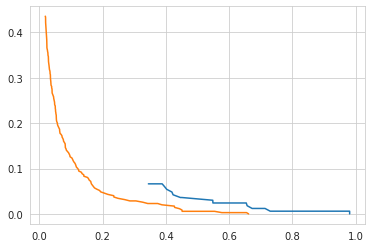

In [46]:
#fpr , fnr , threshold = det_curve(res_data['true_class'] , res_data['PULSAR_prob'] , pos_label='PULSAR')
#plt.plot(threshold , fpr)
fpr , fnr , threshold = det_curve(res_data['true_class'] , res_data['XRB_prob'] , pos_label='XRB')
plt.plot(threshold , fpr)
fpr , fnr , threshold = det_curve(res_data['true_class'] , res_data['PULSAR_prob'] , pos_label='PULSAR')
plt.plot(threshold , fpr)
plt.show()

In [48]:
roc_auc = roc_auc_score(res_data['true_class'] , res_data['XRB_prob'])
roc_auc

0.9967721890427037

## Feature Importance

multiplying the average standardised mean value of each feature split on each class, with the corresponding model._feature_importances array element. You can write a simple function that standardises your dataset, computes the mean of each feature split across class predictions, and does element-wise multiplication with the model._feature_importances array. The greater the absolute resulting values are, the more important the features will be to their predicted class, and better yet, the sign will tell you if it is small or large values that are important.

https://stackoverflow.com/questions/35249760/using-scikit-to-determine-contributions-of-each-feature-to-a-specific-class-pred/35255612

In [49]:
from sklearn.preprocessing import scale
import json
def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = scale(X)

    out = {}
    for c in set(Y):
        print(c)
        out[c] = dict(
            zip(range(M), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )
    return out


In [50]:
feat_imp = best_clf.feature_importances_ 
result = class_feature_importance(x_train , y_train , feat_imp)
#print(json.dumps(result,indent=4))

PULSAR
XRB


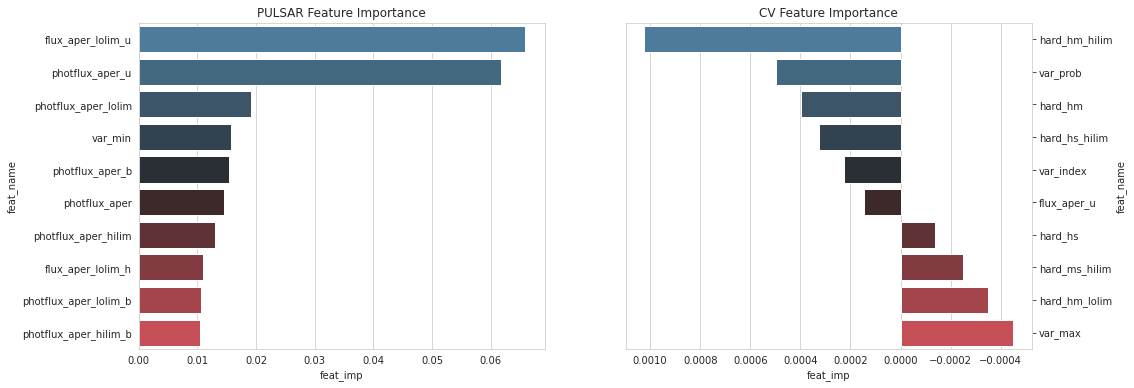

In [52]:
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=2 , figsize=(16,6))
feat_names = x_train.columns.to_list()
top_feat = 10
#result['BH'].keys() = feat_names
values = list(result['PULSAR'].values())
df=  pd.DataFrame()
df.insert(0 , 'feat_name' , feat_names)
df.insert(1 , 'feat_imp' , values)
df = df.sort_values(by='feat_imp' , ascending=False)
df_feat_cla = df.copy() # cla - class A
palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
ax1 = sns.barplot(data = df.iloc[:top_feat,:] ,y = 'feat_name' , x = 'feat_imp'  ,palette = palette, ax=ax[0] )

values = list(result['XRB'].values())
df=  pd.DataFrame()
df.insert(0 , 'feat_name' , feat_names)
df.insert(1 , 'feat_imp' , values)
df = df.sort_values(by='feat_imp' , ascending=False)
df_feat_clb = df.copy() # clb - class B
palette = sns.diverging_palette(240, 10, n=top_feat , center='dark')
ax2 = sns.barplot(data = df.iloc[:top_feat,:] ,y = 'feat_name' , x = 'feat_imp'  ,palette = palette, ax=ax[1] )
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.invert_xaxis()
ax1.set_title('PULSAR Feature Importance')
ax2.set_title('CV Feature Importance')
plt.show()

In [54]:
def is_outlier(points, thresh):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = np.asarray(points)
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation    
    return modified_z_score > thresh

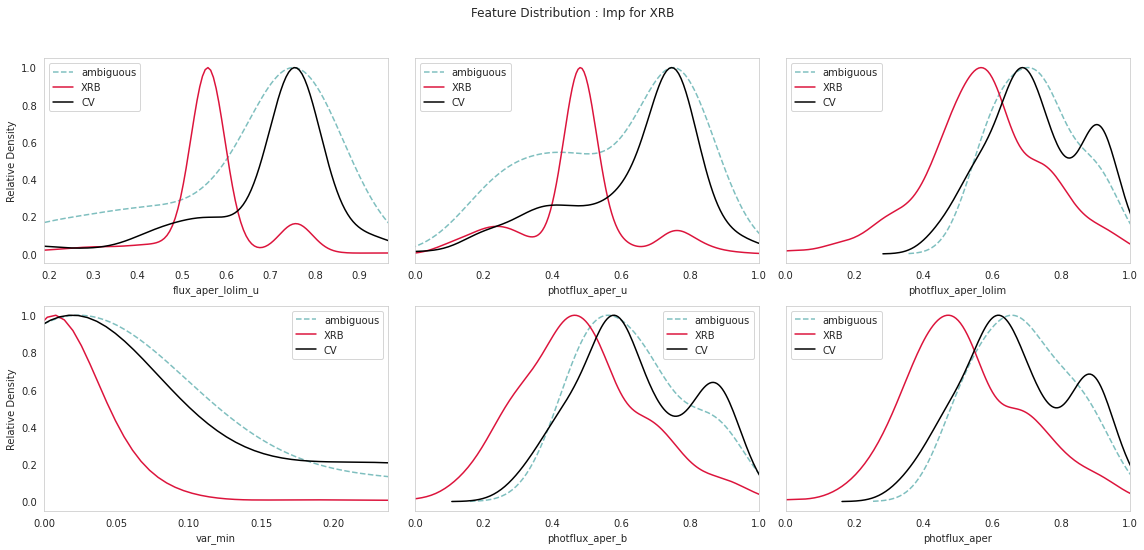

In [55]:
fig, axs = plt.subplots(2,3, sharey=True, sharex=False , figsize=(16 , 8))
col = sns.diverging_palette(240, 10, n=6 , center='dark')
f_name  =  df_feat_cla['feat_name'][:6]
axs = np.ndarray.flatten(axs)
sns.set_style('white')
i = 0 
for f , axi in zip(f_name , axs):
    if(f=='bb_nh_lolim'):
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=150)]
    elif(f=='bb_nh'):
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=100)]
    else:
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=20)]
    #filtered_res = res_data.copy()
    #print(f)
    ax = sns.displot(data = res_data , x = f ,hue = 'true_class' , kind='kde' ,)
    plt.close()
    ax2 = sns.displot(data = res_data[res_data['th_class']=='X'] , x = f ,hue = 'th_class' , kind='kde' ,)
    plt.close()
    amb  , amb_x= ax2.ax.lines[0].get_ydata() , ax2.ax.lines[0].get_xdata()
    amb =  amb / np.amax(amb)
    bh  ,  bh_x = ax.ax.lines[0].get_ydata() , ax.ax.lines[0].get_xdata() 
    bh = bh /np.amax(bh) 
    ns , ns_x = ax.ax.lines[1].get_ydata() , ax.ax.lines[1].get_xdata()
    ns = ns/np.amax(ns)
    #x_val = ax.ax.lines[0].get_xdata() , ax.ax.lines[1].get_xdata()
    #plt.close()
    axi.plot(amb_x , amb , label = 'ambiguous' , color='teal' , alpha=0.5 , linestyle='--')
    axi.plot(ns_x , ns , label = 'XRB' , color='crimson')
    axi.plot(bh_x , bh , label = 'CV' , color = 'black')
    axi.legend()
    axi.set_xlim(np.amin(filtered_res[f]) , np.amax(filtered_res[f]))
    axi.grid(True , color='k' , linestyle=':' , alpha=0.4)
    axi.grid(False)
    axi.set_xlabel(f)
    #axi.set_xscale('log')
    if(not(i%3)):
        axi.set_ylabel('Relative Density')
    i+=1    
    #axi.text(0.1 , 0.1 ,  'Feature : '+f)
fig.suptitle('Feature Distribution : Imp for XRB')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.close()


/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/kumaran/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Attempting to set identical left == right == 0.6392323144850272 results in singular transformations; automatically expanding.


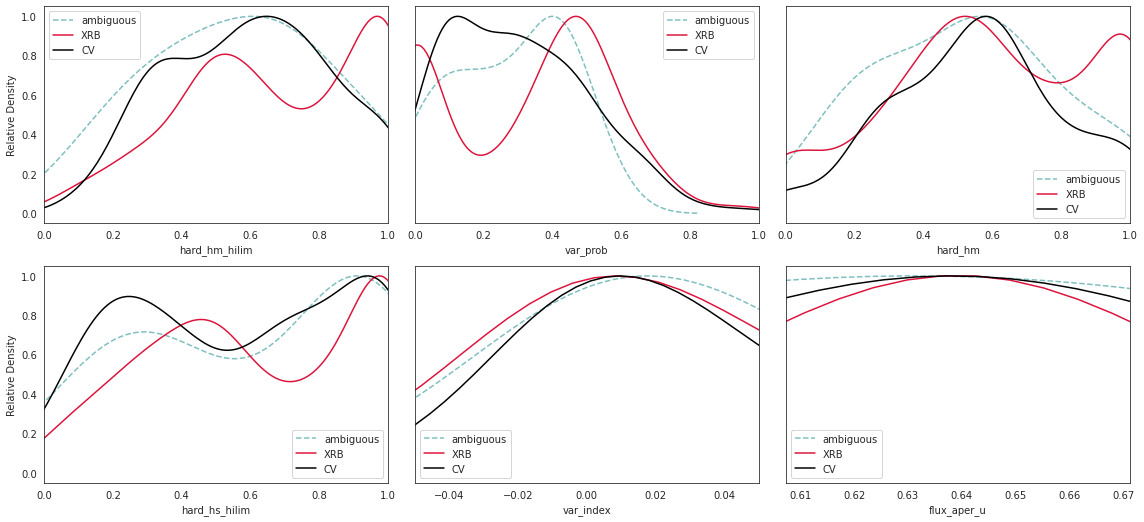

In [56]:
fig, axs = plt.subplots(2,3, sharey=True, sharex=False , figsize=(16 , 8))
col = sns.diverging_palette(240, 10, n=6 , center='dark')
f_name  =  df_feat_clb['feat_name'][:6]
axs = np.ndarray.flatten(axs)
sns.set_style('white')
i = 0 
for f , axi in zip(f_name , axs):
    if(f=='bb_stat'):
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=650)]
    else:
        filtered_res = res_data[~is_outlier(res_data[f] , thresh=350)]
    #filtered_res = res_data.copy()
    #print(f)
    ax = sns.displot(data = res_data , x = f ,hue = 'true_class' , kind='kde' ,)
    plt.close()
    ax2 = sns.displot(data = res_data[res_data['th_class']=='X'] , x = f ,hue = 'th_class' , kind='kde' ,)
    plt.close()
    amb  , amb_x= ax2.ax.lines[0].get_ydata() , ax2.ax.lines[0].get_xdata()
    amb =  amb / np.amax(amb)
    bh  ,  bh_x = ax.ax.lines[0].get_ydata() , ax.ax.lines[0].get_xdata() 
    bh = bh /np.amax(bh) 
    ns , ns_x = ax.ax.lines[1].get_ydata() , ax.ax.lines[1].get_xdata()
    ns = ns/np.amax(ns)
    #x_val = ax.ax.lines[0].get_xdata() , ax.ax.lines[1].get_xdata()
    #plt.close()
    axi.plot(amb_x , amb , label = 'ambiguous' , color='teal' , alpha=0.5 , linestyle='--')
    axi.plot(ns_x , ns , label = 'XRB' , color='crimson')
    axi.plot(bh_x , bh , label = 'CV' , color = 'black')
    axi.legend()
    axi.set_xlim(np.amin(filtered_res[f]) , np.amax(filtered_res[f]))
    axi.grid(True , color='k' , linestyle=':' , alpha=0.4)
    axi.grid(False)
    axi.set_xlabel(f)
    #axi.set_xscale('log')
    if(not(i%3)):
        axi.set_ylabel('Relative Density')
    i+=1    
    #axi.text(0.1 , 0.1 ,  'Feature : '+f)
#fig.suptitle('Feature Distribution')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.close()
